## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
# read the dataset
retail_df = pd.read_csv("Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [5]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [7]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [8]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

We will be doing clustering based on these parameters
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [9]:
# monetary
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [13]:
# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [14]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [15]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [16]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [17]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [18]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [19]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x1677e835dd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1677e866bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1677e82c7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1677e7df750>],
 'fliers': [<matplotlib.lines.Line2D at 0x1677e881690>],
 'means': []}

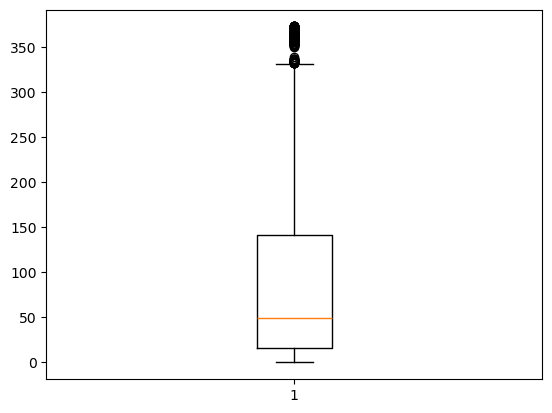

In [20]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x167044364d0>,
 'caps': [<matplotlib.lines.Line2D at 0x16704437d50>,
 'boxes': [<matplotlib.lines.Line2D at 0x16704435b50>],
 'medians': [<matplotlib.lines.Line2D at 0x16704465350>],
 'fliers': [<matplotlib.lines.Line2D at 0x16704465e90>],
 'means': []}

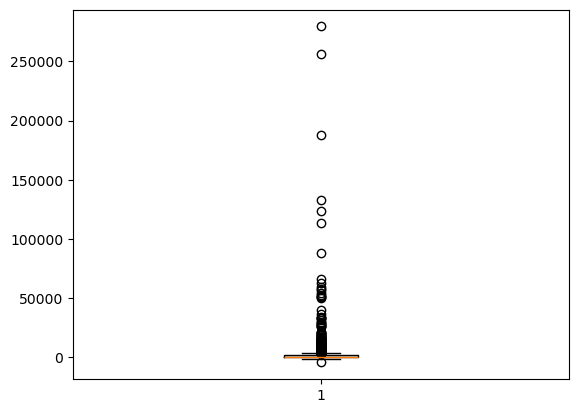

In [21]:
plt.boxplot(grouped_df['amount'])

In [23]:
# two types of outliers:
# - statistical
# - domain specific (Based on our use case)

In [26]:
grouped_df.shape # Before removing outliers 

(4372, 4)

In [27]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [28]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [29]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# 4. Modelling

In [30]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(_BaseKMeans)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |      For an example of how to choose an optimal value for `n_clusters` refer to
 |      :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to t

In [31]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [32]:
kmeans.labels_

array([0, 2, 3, ..., 0, 3, 3])

In [397]:
# help(KMeans)

## Finding the Optimal Number of Clusters

### SSD

Text(0.5, 1.0, 'Elbow Curve')

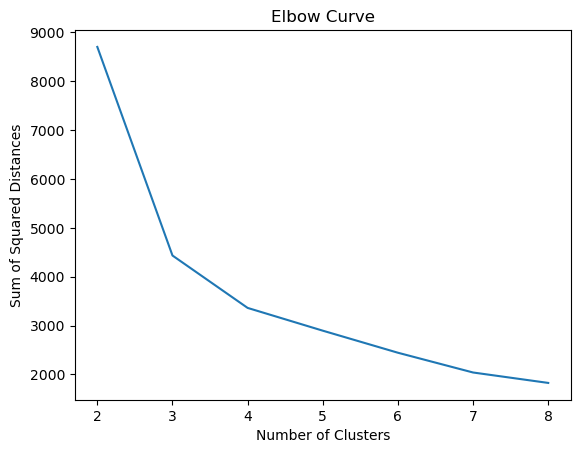

In [34]:
# elbow-curve/SSD
# Sum of Sqared distance

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters, ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve')

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [35]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5085084004374336
For n_clusters=4, the silhouette score is 0.48506020563508856
For n_clusters=5, the silhouette score is 0.4645801831125689
For n_clusters=6, the silhouette score is 0.425932262533818
For n_clusters=7, the silhouette score is 0.4193364436974981
For n_clusters=8, the silhouette score is 0.39340065621219833


In [36]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [37]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [38]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


C:\Users\prakhar\AppData\Local\Temp\ipykernel_25660\1014535294.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_id', y='amount', data=grouped_df, palette='Set3', ax=ax1)
C:\Users\prakhar\AppData\Local\Temp\ipykernel_25660\1014535294.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_id', y='frequency', data=grouped_df, palette='Set3', ax=ax2)
C:\Users\prakhar\AppData\Local\Temp\ipykernel_25660\1014535294.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_id', y='recency', data=grouped_df, palette='Set3'

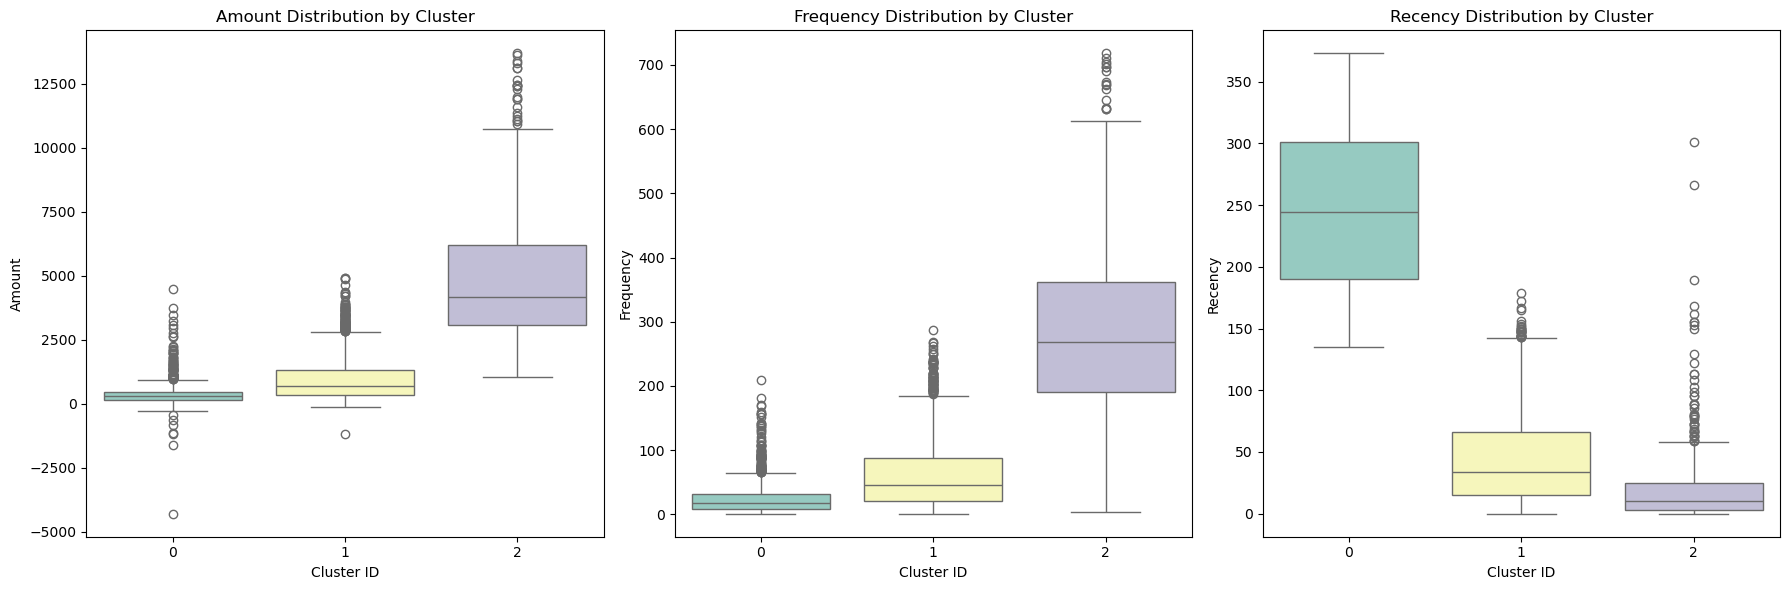

In [43]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='cluster_id', y='amount', data=grouped_df, palette='Set3', ax=ax1)
ax1.set_title('Amount Distribution by Cluster')
ax1.set_xlabel('Cluster ID')
ax1.set_ylabel('Amount')

sns.boxplot(x='cluster_id', y='frequency', data=grouped_df, palette='Set3', ax=ax2)
ax2.set_title('Frequency Distribution by Cluster')
ax2.set_xlabel('Cluster ID')
ax2.set_ylabel('Frequency')

sns.boxplot(x='cluster_id', y='recency', data=grouped_df, palette='Set3', ax=ax3)
ax3.set_title('Recency Distribution by Cluster')
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Recency')

plt.tight_layout()
plt.show()

## Hierarchical Clustering

In [406]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [407]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


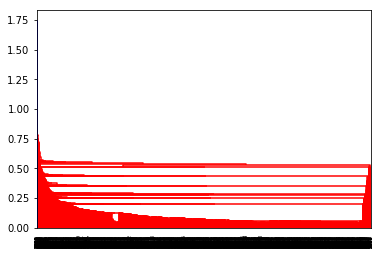

In [408]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

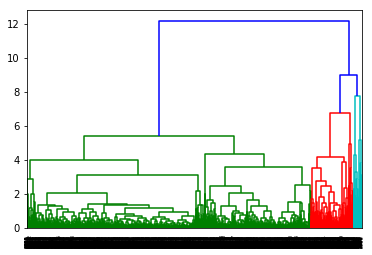

In [409]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [415]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [416]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


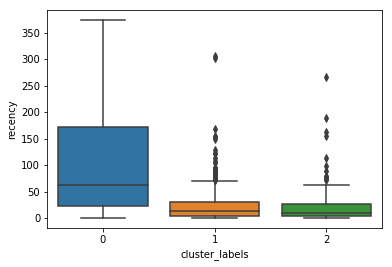

In [419]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

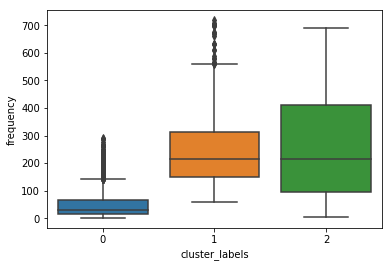

In [420]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

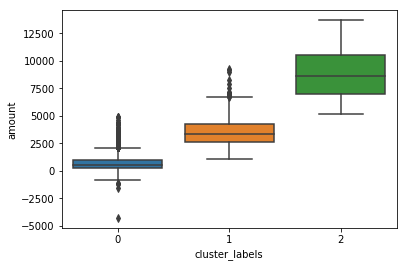

In [421]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)